In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [9]:
filepath = "./data/processed_production_data.csv"
df_post_peak = pd.read_csv(filepath)

alias_filepath = "./data/operator_aliasing.csv"
df_alias = pd.read_csv(alias_filepath)

wells_filepath = "./data/wellsData.csv"
df_wells = pd.read_csv(wells_filepath)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (21,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
def plot_prod_curve(basin_data_pre, basin_data_post, y_label):
    data_pre = basin_data_pre.apply(lambda x: x.values.tolist()).tolist()
    data_post = basin_data_post.apply(lambda x: x.values.tolist()).tolist()
    
    mean_pre = basin_data_pre.apply(lambda x: np.mean(x.values)).tolist()
    mean_post = basin_data_post.apply(lambda x: np.mean(x.values)).tolist()
    
    median_pre = basin_data_pre.apply(lambda x: np.median(x.values)).tolist()
    median_post = basin_data_post.apply(lambda x: np.median(x.values)).tolist()
    
    p90_pre = basin_data_pre.apply(lambda x: np.percentile(x.values, 90)).tolist()
    p90_post = basin_data_post.apply(lambda x: np.percentile(x.values, 90)).tolist()
    
    x = np.arange(1,37).tolist()
        
    fig = plt.figure(constrained_layout=True, figsize=(13,3))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    
    f_ax1 = fig.add_subplot(spec[0, 0])
    f_ax2 = fig.add_subplot(spec[0, 1])
    
    f_ax1.yaxis.set_ticks(np.arange(0, 40000, 5000))
    f_ax1.set_ylim(0,37000)
    f_ax1.set_title('Before 2014')
    f_ax1.set_ylabel(y_label)
    f_ax1.boxplot(data_pre, showfliers=False)
    f_ax1.plot(x, p90_pre, color='steelblue', label='90th Percentile')
    f_ax1.plot(x, mean_pre, color='orange', label='Mean')
    f_ax1.plot(x, median_pre, color='green', label='Median')
    f_ax1.legend(loc="upper right")
    
    f_ax2.yaxis.set_ticks(np.arange(0, 40000, 5000))
    f_ax2.set_ylim(0,37000)
    f_ax2.set_title('After 2014')
    f_ax2.boxplot(data_post, showfliers=False)
    f_ax2.plot(x, p90_post, color='steelblue', label='90th Percentile')
    f_ax2.plot(x, mean_post, 'orange', label='Mean')
    f_ax2.plot(x, median_post, color='green', label='Median')
    f_ax2.legend(loc="upper right")

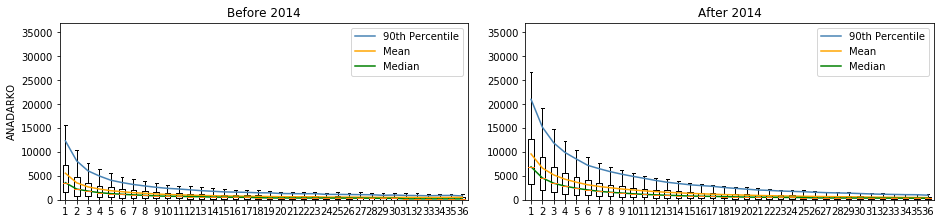

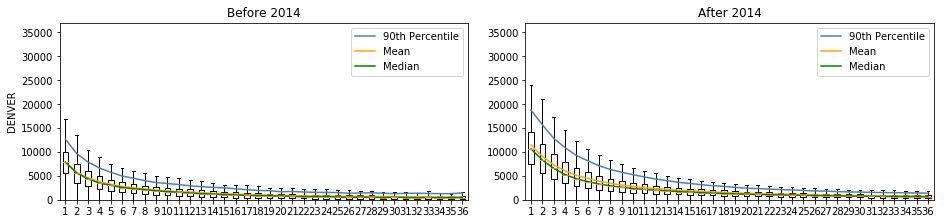

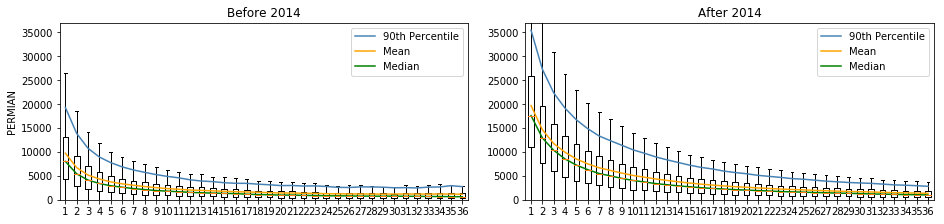

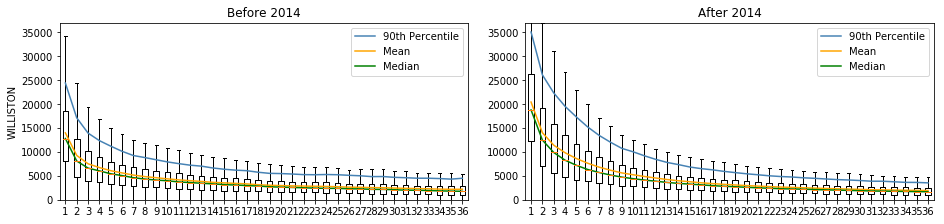

In [11]:
basin_names = ['ANADARKO BASIN', 'DENVER BASIN', 'PERMIAN BASIN', 'WILLISTON BASIN']

for basin in basin_names:
    basin_post_peak = df_post_peak[np.logical_and(df_post_peak['MonthIdx']<37, df_post_peak['API'].isin(df_wells[df_wells['BasinName']==basin]['API']))]
    
    basin_post_peak_pre = basin_post_peak[basin_post_peak['Year']<2014]
    basin_post_peak_pre_dist = basin_post_peak_pre.groupby(['MonthIdx'])['Liquid']
    
    basin_post_peak_post = basin_post_peak[basin_post_peak['Year']>=2014]
    basin_post_peak_post_dist = basin_post_peak_post.groupby(['MonthIdx'])['Liquid']
    plot_prod_curve(basin_post_peak_pre_dist, basin_post_peak_post_dist, basin.split(' ')[0])